## Data import

In [2]:
import pandas as pd
import numpy as np
from pyspark.sql.functions import *
from pyspark.ml.feature import Tokenizer, StopWordsRemover, CountVectorizer, HashingTF, IDF, StringIndexer
from pyspark.ml.pipeline import Pipeline
from pyspark.ml.classification import NaiveBayes, LinearSVC, DecisionTreeClassifier, GBTClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.mllib.evaluation import MulticlassMetrics

import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
!pip install wordcloud

In [4]:
from wordcloud import WordCloud

In [5]:
ACCESS_KEY = ""
SECRET_KEY = ""
ENCODED_SECRET_KEY = SECRET_KEY.replace("/", "%2F")
BUCKET_NAME = "spam"
MOUNT_NAME = "spam"

try:
  dbutils.fs.unmount("/mnt/%s/" % MOUNT_NAME)
except:
  print("Could not unmount %s for first time import." % MOUNT_NAME)

dbutils.fs.mount("s3a://%s:%s@%s" % (ACCESS_KEY, ENCODED_SECRET_KEY, BUCKET_NAME), "/mnt/%s" % MOUNT_NAME)
display(dbutils.fs.ls("/mnt/%s" % MOUNT_NAME))

path,name,size
dbfs:/mnt/spam/spam.csv,spam.csv,503663


## Preprocessing & EDA

In [7]:
spam = spark.read.format('csv')\
            .options(header='true', inferSchema='true')\
            .load('/mnt/spam/spam.csv')
spam.show(10)

+----+--------------------+----+----+----+
 v1| v2| _c2| _c3| _c4|
+----+--------------------+----+----+----+
 ham|Go until jurong p...|null|null|null|
 ham|Ok lar... Joking ...|null|null|null|
spam|Free entry in 2 a...|null|null|null|
 ham|U dun say so earl...|null|null|null|
 ham|Nah I don't think...|null|null|null|
spam|FreeMsg Hey there...|null|null|null|
 ham|Even my brother i...|null|null|null|
 ham|As per your reque...|null|null|null|
spam|WINNER!! As a val...|null|null|null|
spam|Had your mobile 1...|null|null|null|
+----+--------------------+----+----+----+
only showing top 10 rows

In [8]:
spam.printSchema()

root
-- v1: string (nullable = true)
-- v2: string (nullable = true)
-- _c2: string (nullable = true)
-- _c3: string (nullable = true)
-- _c4: string (nullable = true)

Drop the last three columns which are not relevant for the task

In [10]:
columns_to_drop = ['_c2', '_c3', '_c4']
spam = spam.drop(*columns_to_drop)

Rename the first two columns

In [12]:
spam = spam.withColumnRenamed('v1','label')
spam = spam.withColumnRenamed('v2','text')
spam.show(10)

+-----+--------------------+
label| text|
+-----+--------------------+
 ham|Go until jurong p...|
 ham|Ok lar... Joking ...|
 spam|Free entry in 2 a...|
 ham|U dun say so earl...|
 ham|Nah I don't think...|
 spam|FreeMsg Hey there...|
 ham|Even my brother i...|
 ham|As per your reque...|
 spam|WINNER!! As a val...|
 spam|Had your mobile 1...|
+-----+--------------------+
only showing top 10 rows

In [13]:
spam.count()

Out[9]: 5574

### Missing values

In [15]:
spam.where('label is NULL or text is NULL').show()

+------+----+
 label|text|
+------+----+
ham"""|null|
+------+----+

In [16]:
# Drop missing values
spam = spam.dropna()
spam.count()

Out[11]: 5573

Reformat labels

In [18]:
spam.select('label').distinct().show()

+------+
 label|
+------+
ham"""|
 ham|
 spam|
+------+

In [19]:
spam = spam.withColumn('label', regexp_replace('label', '"""', ''))

In [20]:
spam.select('label').distinct().show()

+-----+
label|
+-----+
 ham|
 spam|
+-----+

### Class balance

In [22]:
spam.groupby('label').count().show()

+-----+-----+
label|count|
+-----+-----+
 ham| 4826|
 spam| 747|
+-----+-----+

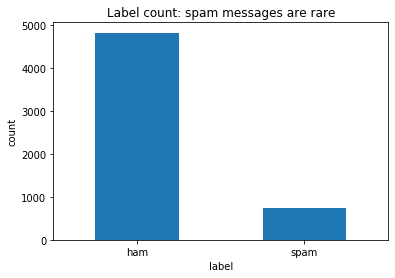

In [23]:
label_count = spam.groupby('label').count().toPandas()
label_count.plot(x='label', y='count', kind='bar', legend=None)
plt.xticks(rotation=0)
plt.ylabel('count')
plt.title('Label count: spam messages are rare')

### Wordcloud

In [25]:
def plot_wordcloud(df, label):
  condition = 'label=\"' + label + '\"'
  print(condition)
  text = df.filter(condition)\
           .select('text')\
           .rdd.flatMap(lambda x: x)\
           .collect() # list of strings
  text = ''.join(str(t) for t in text) # string
  
  wordcloud = WordCloud(max_font_size=50, 
                        max_words=100, 
                        background_color='white').generate(text)

  plt.figure(figsize=(10, 6))
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis('off')
  plt.title(label, fontsize=15)
  plt.show()

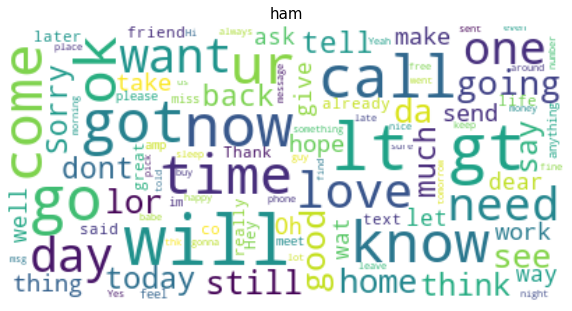

In [26]:
plot_wordcloud(spam, 'ham')

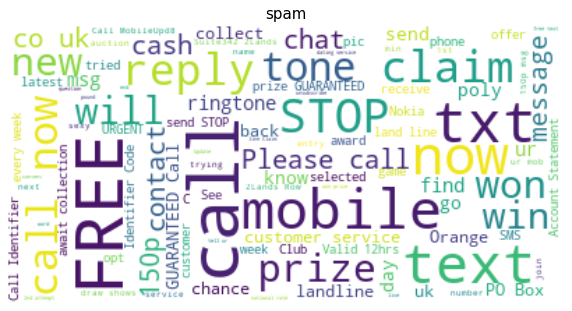

In [27]:
plot_wordcloud(spam, 'spam')

- Non-spam messages: sentiment words (e.g., love, good, ok, sorry)
- Spam messages: ad-related words (e.g., free, call, mobile, claim, txt, text)

### Message length

In [30]:
spam = spam.withColumn('length', length('text'))

In [31]:
spam.show(5)

+-----+--------------------+------+
label| text|length|
+-----+--------------------+------+
 ham|Go until jurong p...| 111|
 ham|Ok lar... Joking ...| 29|
 spam|Free entry in 2 a...| 155|
 ham|U dun say so earl...| 49|
 ham|Nah I don't think...| 61|
+-----+--------------------+------+
only showing top 5 rows

In [32]:
spam.groupby('label').agg(min('length'), max('length'), avg('length')).show()

+-----+-----------+-----------+------------------+
label|min(length)|max(length)| avg(length)|
+-----+-----------+-----------+------------------+
 ham| 2| 910| 71.07065893079155|
 spam| 13| 223|138.45917001338688|
+-----+-----------+-----------+------------------+

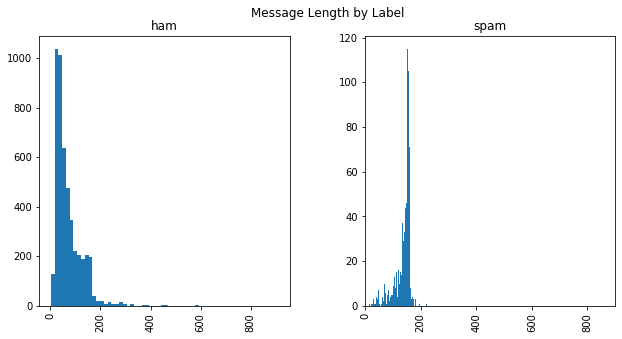

In [33]:
length = spam.select('label', 'length').toPandas()
length.hist(column='length', by='label', bins=60, figsize=(10, 5))
plt.suptitle('Message Length by Label')
plt.xlim(0, 900)

Spam messages seem to be longer.

### Train-test-split

In [36]:
SEED=42
train, test = spam.randomSplit([0.8, 0.2], seed=SEED)

In [37]:
train.count(), test.count()

Out[25]: (4502, 1071)

### Text preprocessing
- Tokenization
- Removing stopwords
- Vectorization (CountVectorizer, HashingTF)
- TF-IDF weighting

### Label preprocessing
- Map labels to numerical indices

The preprocessing steps will be integrated in the model pipeline and tuned.

## Model

In [41]:
def fit_model(model_name, train=train, test=test, 
              vectorizer='count', 
              tuning=False, num_folds=5, 
              results=None, return_fitted=False):
  
  # Instantiate models
  label_col, features_col = 'label_index', 'features'
  model_dict = {
    'nb': NaiveBayes(labelCol=label_col, featuresCol=features_col),
    'svm': LinearSVC(labelCol=label_col, featuresCol=features_col),
    'dt': DecisionTreeClassifier(labelCol=label_col, featuresCol=features_col, seed=SEED),
    'gbt': GBTClassifier(labelCol=label_col, featuresCol=features_col, seed=SEED)
  }
  model = model_dict[model_name]
  
  # Text preprocessing
  label_indexer = StringIndexer(inputCol='label',outputCol='label_index')
  tokenizer = Tokenizer(inputCol='text', outputCol='words')
  remover = StopWordsRemover(inputCol='words', outputCol='words_filtered')
  
  if vectorizer == 'count':
    cv = CountVectorizer(inputCol='words_filtered', outputCol='features', vocabSize=10000)
    pipeline = Pipeline(stages=[tokenizer,
                                remover,
                                cv,
                                label_indexer,
                                model])
  else:
    hashingTF = HashingTF(inputCol='words_filtered', outputCol='tf', numFeatures=10000)
    idf = IDF(inputCol='tf', outputCol='features')
    pipeline = Pipeline(stages=[tokenizer,
                                remover,
                                hashingTF,
                                idf,
                                label_indexer,
                                model])
  
  evaluator = MulticlassClassificationEvaluator(labelCol='label_index', 
                                                predictionCol='prediction',
                                                metricName='accuracy')
  # Tuning option
  if tuning:
    if vectorizer == 'count':
      param_grid = ParamGridBuilder()\
        .addGrid(cv.vocabSize, [1000, 5000, 10000])\
        .addGrid(cv.minDF, [2, 4])\
        .addGrid(model.smoothing, [0.0, 0.5, 1.0])\
        .build()
    else:
      param_grid = ParamGridBuilder()\
        .addGrid(hashingTF.numFeatures, [1000, 5000, 10000])\
        .addGrid(idf.minDocFreq, [2, 4])\
        .addGrid(model.smoothing, [0.0, 0.5, 1.0])\
        .build()
    
    pipeline = CrossValidator(estimator=pipeline,
                              estimatorParamMaps=param_grid,
                              evaluator=evaluator,
                              numFolds=num_folds) 
    pipeline = pipeline.fit(train)
    predictions = pipeline.bestModel.transform(test)
  else: 
    pipeline = pipeline.fit(train)
    predictions = pipeline.transform(test)
  
  # Evaluation
  acc = evaluator.evaluate(predictions)
  print(f'Test set accuracy: {100*acc:.2f}')
  
  res = pd.DataFrame([[model_name, acc]], columns=['classifier', 'test_acc'])
  
  if return_fitted:
    return pipeline, predictions
  
  if results is None:
    results = pd.DataFrame(columns=['classifier', 'test_acc'])
    
  return pd.concat([results, res])

### Naive Bayes

In [43]:
model_results = fit_model('nb')

Test set accuracy: 98.51

In [44]:
_ = fit_model('nb', vectorizer='tfidf')

Test set accuracy: 94.12

Remark on the two vectorizers
- HashingTF is more efficient, but irreversible. 
- Hashed input can be harder to interpret and monitor.
- We will use CountVectorizer as it stores vocabulary, which can be useful when determining words that are likely to be in spams.

### SVM

In [47]:
model_results = fit_model('svm', results=model_results)

Test set accuracy: 97.48

### Decision Tree

In [49]:
model_results = fit_model('dt', results=model_results)

Test set accuracy: 92.62

### Gradient-boosted Tree

In [51]:
model_results = fit_model('gbt', results=model_results)

Test set accuracy: 94.96

In [52]:
model_results.sort_values(by='test_acc', ascending=False)

,classifier,test_acc
0,nb,0.985061
0,svm,0.974790
0,gbt,0.949580
0,dt,0.926237


SVM and Naive Bayes have better performances and are more efficient in terms of runtime. 

Indeed, these are among the most popular classifiers for spam detection.

### Tuning Naive Bayes

In [55]:
nb_cv, predictions = fit_model('nb', tuning=True, return_fitted=True)

/databricks/spark/python/pyspark/ml/util.py:737: UserWarning: Cannot find mlflow module. To enable MLflow logging, install mlflow from PyPI.
 warnings.warn(_MLflowInstrumentation._NO_MLFLOW_WARNING)
Test set accuracy: 98.51

In [56]:
print('Best parameter setting:')
print('vocabSize=', nb_cv.bestModel.stages[2].getVocabSize())
print('minDF=', nb_cv.bestModel.stages[2].getMinDF())
print('Smoothing=', nb_cv.bestModel.stages[-1].getSmoothing())

Best parameter setting:
vocabSize= 5000
minDF= 2.0
Smoothing= 1.0

### Evaluation

In [58]:
pred_actual = predictions.select('prediction', 'label_index').rdd

# Generate confusion matrix
metrics = MulticlassMetrics(pred_actual)
print(metrics.confusionMatrix())

DenseMatrix([[919., 4.],
 [ 12., 136.]])

In [59]:
predictions.select('label_index', 'prediction')\
  .filter('label_index = 1')\
  .show(10)

+-----------+----------+
label_index|prediction|
+-----------+----------+
 1.0| 0.0|
 1.0| 1.0|
 1.0| 1.0|
 1.0| 1.0|
 1.0| 1.0|
 1.0| 1.0|
 1.0| 1.0|
 1.0| 1.0|
 1.0| 1.0|
 1.0| 0.0|
+-----------+----------+
only showing top 10 rows

### Feature importance

In [61]:
features = nb_cv.bestModel.stages[2].vocabulary

In [62]:
# theta: log of class conditional probabilities
theta_0 = nb_cv.bestModel.stages[-1].theta.toArray()[0] # Class 0: no-spam
theta_1 = nb_cv.bestModel.stages[-1].theta.toArray()[1] # Class 1: spam

In [63]:
feature_imp = pd.DataFrame({'feature': features,
                            'theta_0': theta_0,
                            'theta_1': theta_1})

In [64]:
top_20 = feature_imp[['feature', 'theta_1']].sort_values(by='theta_1', ascending=False).head(20)

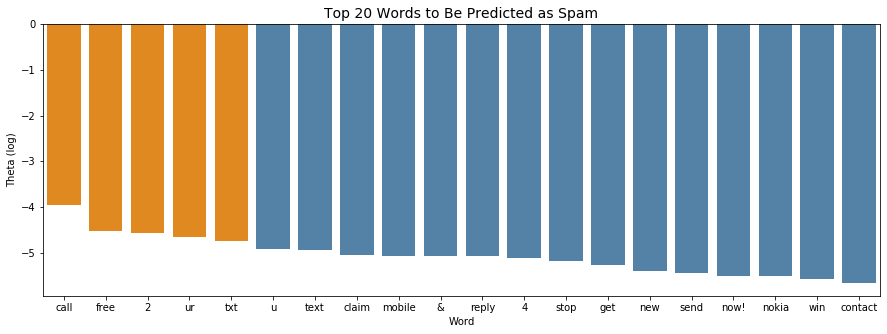

In [65]:
fig, ax = plt.subplots(figsize=(15, 5))
colors = ['darkorange' if (t in top_20.theta_1[:5].tolist()) else 'steelblue' for t in top_20.theta_1]
sns.barplot(x='feature', y='theta_1', data=top_20,
            ax=ax, palette=colors)
ax.set_xlabel('Word')
ax.set_ylabel('Theta (log)')
ax.set_title('Top 20 Words to Be Predicted as Spam', fontsize=14)

Based on `theta`, which is the log of class conditional probabilities, we found the top 20 words that will be predicted as spam by our model. Such a finding aligns with the wordcloud we formed before. 

In conclusion, common spam-trigger words are
- Manipulative words, e.g., 'call'. 'reply', 'send', 'contact', 'now'
- Needy workds, e.g., 'free'